In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'


In [4]:
sra_dump_df=pd.read_pickle(sra_dump_pickle_dir)

In [5]:
"""
ERP013950: some guy deposited tons of synthetic reads and annotate them as WGS
"""
blackListSrps=['ERP013950']

In [6]:
publicDf=sra_dump_df[(sra_dump_df.proj_accession_Visibility=='public')&(~sra_dump_df.Study.isin(blackListSrps))]

In [7]:
VC=publicDf.groupby(['ScientificName','LibraryStrategy']).size()

In [8]:
VC=VC.sort_values(ascending=False)

In [9]:
countBySrategy=VC.groupby('LibraryStrategy').sum()
ignore_strategy_list=(countBySrategy.index[countBySrategy<5000]
).tolist()
countBySpecie=VC.groupby('ScientificName').sum()
ignore_specie_list=countBySpecie.index[countBySpecie<20000].tolist()

In [10]:
m2=~VC.index.get_level_values('LibraryStrategy').isin(['CLONE','POOLCLONE','SELEX','OTHER','RAD-seq','RAD-Seq']+ignore_strategy_list)
m3=~VC.index.get_level_values('ScientificName').isin([u'synthetic_construct']+ignore_specie_list)
subVC=VC[m2&m3].reorder_levels(['LibraryStrategy','ScientificName']).sort_index()#.unstack()

In [11]:
library_order=subVC.groupby('LibraryStrategy').sum().sort_values(ascending=False).index.astype(np.str)

scientific_order=subVC.groupby('ScientificName').sum().sort_values(ascending=False).index.astype(np.str)

In [12]:
yLabel='# of sequencing runs'

In [13]:
### stacked bar 

In [14]:
sortedS=subVC.sort_values(ascending=False).groupby(level='LibraryStrategy').head(15)

In [15]:
unstackDf=sortedS.unstack()

In [16]:
inPlotDf2=unstackDf.copy()

In [17]:
inPlotDf2.index=inPlotDf2.index.astype(np.str)
inPlotDf2.columns=inPlotDf2.columns.astype(np.str)

In [18]:
tmpS2=inPlotDf2.columns.to_series()
tmpS2[tmpS2.str.contains('metagenome')]='metagenome'
plants=['Arabidopsis_thaliana','Oryza_sativa',u'Hordeum_vulgare_subsp._vulgare']
tmpS2[tmpS2.str.contains("|".join(plants))]='Plants'
prokaryotes=[u'Mycobacterium_tuberculosis',u'Plasmodium_falciparum',u'Saccharomyces_cerevisiae','Salmonella_enterica',
            u'Salmonella_enterica_subsp._enterica','Staphylococcus_aureus',u'Escherichia_coli',u'Streptococcus_pneumoniae']
tmpS2[tmpS2.str.contains("|".join(prokaryotes))]='Prokaryotes: '
inPlotDf2.columns=tmpS2.values



In [19]:
tmpS3=inPlotDf2.index.to_series()
tmpS3[tmpS3.str.contains('rna-seq',case=False)]='RNA-seq'
tmpS3[tmpS3.str.contains('ATAC|DNase|chip',case=False)]='Chip / ATAC / DNase\n-seq'
tmpS3[tmpS3.str.contains('^WGA|WGS$',case=False)]='WGS'



inPlotDf2.index=tmpS3.values

In [20]:
inPlotDf3=inPlotDf2.groupby(level=0,axis=1).sum().groupby(level=0,axis=0).sum()

In [21]:
x_order3=inPlotDf3.sum(axis=1).sort_values(ascending=False).index
y_order3=inPlotDf3.sum(axis=0).sort_values(ascending=False).index

# data break down by organism and omic layer

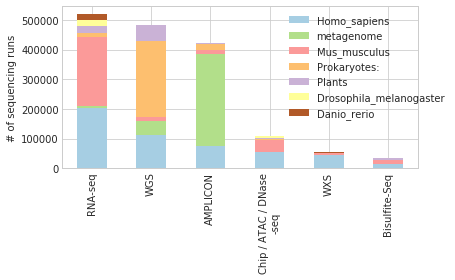

In [34]:
ax=inPlotDf3.loc[x_order3,y_order3].iloc[:-3].plot.bar(stacked=True,colormap='Paired')
ax.set_ylabel('# of sequencing runs')
ax.legend(bbox_to_anchor=(1.1,1))
ax.figure.tight_layout()
ax.figure.savefig('./Figures/sra_data_availability.png',dpi=300,bbox_to_anchor='tight')

In [26]:
#fig,ax=plt.subplots()
#epigenome, only the cpg sites. 

In [27]:
myDate='proj_accession_Received'
inPlotDf2=publicDf#sra_dump_df[sra_dump_df['proj_accession_Visibility']=='public']
#diffS=(inPlotDf2[myDate].astype(np.datetime64)-np.datetime64('2008','Y'))
a=inPlotDf2[myDate].astype(np.datetime64)
perYear=a.map(lambda s:s.year)


In [28]:
validYear=perYear[perYear>=2008].astype(np.int)

In [29]:
countS=validYear.value_counts()
countS=countS.sort_index()

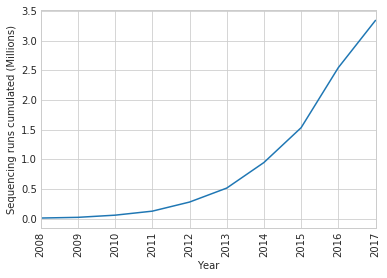

In [30]:
cumulativeS=countS.cumsum()
adjustedS=cumulativeS/10**6
ax=adjustedS.plot()
ax.set_ylabel('Sequencing runs cumulated (Millions)')
ax.set_xticklabels(cumulativeS.index.astype(np.str), rotation='vertical')

ax.set_yscale('linear')
ax.set_xlabel('Year')
ax.figure.savefig('./Figures/sra_data_availability_over_time.png',dpi=300)

In [134]:
#one_peta_bytes=10**16

In [135]:
print 'number of peta basess of data: ', sra_dump_df['Bases'].sum()/one_peta_bytes

number of peta basess of data:  1.39874500912


### scratches

In [151]:
millionBases=sra_dump_df['Bases'].sum()/(10**6)

In [168]:
75*cost_per_mb

3.75

In [169]:
cost_per_mb=0.05
#1 cent per a million 
np.log10(millionBases*cost_per_mb)

8.8447085542647343

In [170]:
millionBases*cost_per_mb/(10**6)

699.3725045620188

In [176]:
sra_dump_df['Run']=sra_dump_df.index

In [179]:
indexedDf=sra_dump_df.set_index(['Study','Sample','Experiment','Run'])

In [183]:
#indexedDf.head()

In [184]:
#indexedDf[['ScientificName','LibraryStrategy','LibraryLayout']].iloc[100:]

In [8]:
## so as the meta data 
tmpDf3=publicDf[(publicDf.ScientificName=='Homo_sapiens')&(~publicDf.Study.isin(['ERP013950']))]

In [15]:
n_bases=tmpDf3['Bases'].sum()

In [21]:
nBytes=n_bases/2

In [23]:
nGb=(nBytes/10**9)*2

In [24]:
nGb

1834995.522362079